# AirBnb Feature Importance Project

## Motivation

Traveling to a nice touristic cosmopolitan city is different to travel to a small city or to a not so turistic one. Thats clear in our minds and there is no doubt about it. But could we tell the most important characteristics of an AirBnb acomodation that differ between the most visited cities and the not so visited ones. <br>

With that said, the main motivation of the project is translated into the following research questions:

### Research Questions
1. Which are the 10 most important characteristics to influence the overall review of an acomodation?
2. What are the general differences between a top rated acomodation and a almost top one?
3. Which are the main review aspects that influences the overall review score?
4. How would be the most likely description of a acomodation in a small city like Salem, Oregon based on the findings of this study?


## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import gzip
from io import BytesIO
import re
from decimal import Decimal

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

import lightgbm as lgb
from xgboost import XGBRegressor

[nltk_data] Downloading package vader_lexicon to C:\Users\DTI
[nltk_data]     Digital\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Toolkit functions

In [2]:
def remove_nonnumeric_chars(s):
    '''
    INPUT:
    s - numeric string with non-numeric charachters

    OUTPUT:
    np.float16 - numeric value before the dot
    '''
    try:
        return np.float64(Decimal(re.sub(r'[^\d.]', '', s)))
    except:
        return np.nan

In [3]:
def create_dummy_df(df, cat_cols, dummy_na, drop_first=True):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    
    cat_df_out = pd.get_dummies(df[cat_cols], prefix=cat_cols, prefix_sep='_', dummy_na=dummy_na, drop_first=drop_first)
    df_out     = cat_df_out.join(df.drop(cat_cols, axis=1))

    return df_out

In [4]:
def get_sequences(vector, split_val):
    ''''
    INPUT:
    vector - raw serie (pd.Series)
    split_val - reference str to split the series

    OUTPUT:
    median, mean, max, min values of the sequences found in the serie
    '''    
    sequences = ''.join([str(val) for val in vector]).split(split_val)
    sequences_count = [len(val) for val in sequences]
    sequences_cleansed = [val for val in sequences_count if val>0]

    if len(sequences_cleansed) > 0:
        return np.median(sequences_cleansed), np.mean(sequences_cleansed), np.max(sequences_cleansed), np.min(sequences_cleansed)
    else:
        return 0,0,0,0

In [5]:
def plot_importance(data, feature, title=None ,rows=10):
    '''
    INPUT:
    data - dataframe based on which the plot will be done
    feature - feature to plot
    title - plot title, default=None
    rows - number of rows to show
    '''
    corr_abs = data.iloc[:rows]
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5,7), dpi=200)#, sharey=True)
    gs = fig.add_gridspec(1, 3)

    sns.heatmap(corr_abs, annot=True, cmap='magma_r', cbar=False,ax=ax[0])
    sns.barplot(x=feature, y=corr_abs.index, data=corr_abs, palette="magma")

    ax[0].axes.get_xaxis().set_visible(False)
    ax[1].axes.get_xaxis().set_visible(False)
    ax[1].axes.get_yaxis().set_visible(False)

    fig.suptitle(title, fontsize=20)
    sns.despine(bottom=True)

## ETL

### tourism data

In [39]:
# read and load tourism data
tourism = pd.read_csv('datasets/raw/city_tourism.csv',sep=';')
# making sure to cleanse the names
for col in ['city','city_name','state','region','country']:
    tourism[col] = tourism[col].apply(lambda x: x.strip())
# preparing the cities names to iterate through the cities
cities = tourism['city'].values


### calendar data

In [41]:
trusted_calendar_dataset = pd.DataFrame()

for city in tqdm(cities):
    # defining path to read data
    calendar_path = f'datasets/raw/{city}/calendar.csv.gz'

    # extracting data
    with gzip.open(calendar_path,'r') as f:
        df_calendar = pd.read_csv(BytesIO(f.read()))

    # dropping NaN values (not much missing values)
    df_calendar.dropna(inplace=True)
    
    # object to numeric transformation
    toNumeric_columns =  ['price','adjusted_price']
    for col in toNumeric_columns:
        df_calendar[col] = df_calendar[col].apply(remove_nonnumeric_chars)

    # str to datetime transformation
    df_calendar['date'] = pd.to_datetime(df_calendar['date'])

    # dealing with categorical values
    cat_cols_lst = ['available']
    df_calendar = create_dummy_df(df_calendar, cat_cols_lst, dummy_na=False)

    # Aggregating by listing_id
    df_calendar_agg = df_calendar.groupby('listing_id').agg({'date':['min','max'],
                                                        'price':['min', 'max', 'mean'], 
                                                        'minimum_nights':['min','max','mean'], 
                                                        'maximum_nights':['min','max'],
                                                        'available_t':'sum'
                                                        })  
    
    # Renaming aggregated columns
    # concat agg column names
    col_names = []
    for cols in df_calendar_agg.columns:
        new_col = '_'.join(cols)
        col_names.append(new_col)

    # rename columns
    df_calendar_agg.columns = col_names


    # Feature engineering
    # number of days online
    df_calendar_agg['online_days'] = (df_calendar_agg['date_max']-df_calendar_agg['date_min']).apply(lambda x: x.days)+1
    df_calendar_agg.drop('date_max', axis=1, inplace=True)
    df_calendar_agg.drop('date_min', axis=1, inplace=True)
    # occupied days
    df_calendar_agg['ocupied_days'] = df_calendar_agg['online_days'] - df_calendar_agg['available_t_sum']
    # total revenue generated by the allocation
    df_calendar_agg['revenue'] = df_calendar_agg['ocupied_days'] * df_calendar_agg['price_mean']
    # ocupation rate
    df_calendar_agg['ocupation_rate'] = df_calendar_agg['ocupied_days'] / df_calendar_agg['online_days']
    # geographical and tourism data
    df_calendar_agg['city'] = city
    df_calendar_agg = df_calendar_agg.join(tourism.set_index('city'), on='city', how='left')
    df_calendar_agg['foreign_visitors']    = df_calendar_agg['foreign_visitors'].astype('str').apply(lambda x: re.sub('\.', '', x))
    df_calendar_agg['visitors_per_capita'] = df_calendar_agg['visitors_per_capita'].apply(lambda x: re.sub(',','.',x)).astype(np.float64)

    # calculating relative price based on each city
    df_calendar_agg['price_mean_rel'] = df_calendar_agg['price_mean'] / df_calendar_agg['price_mean'].mean()
    df_calendar_agg['price_min_rel'] = df_calendar_agg['price_min'] / df_calendar_agg['price_min'].mean()
    df_calendar_agg['price_max_rel'] = df_calendar_agg['price_max'] / df_calendar_agg['price_max'].mean()

    # calculating ocupation statistics
    d = {'listing_id':[],
        'ocupation_duration_median':[],
        'ocupation_duration_mean':[],
        'ocupation_duration_max':[],
        'ocupation_duration_min':[]
        }
    # loop through each acomodation to impute the statistics
    for listing_id in df_calendar_agg.index:
        vector = df_calendar.loc[df_calendar['listing_id']==listing_id]['available_t']
        median_val, mean_val, max_val, min_val = get_sequences(vector, '1')
        d['listing_id'].append(listing_id) 
        d['ocupation_duration_median'].append(median_val)
        d['ocupation_duration_mean'].append(mean_val)
        d['ocupation_duration_max'].append(max_val)
        d['ocupation_duration_min'].append(min_val)
    # join with calculated statistics
    ocupation_duration_stats = pd.DataFrame(d)
    df_calendar_agg = df_calendar_agg.join(ocupation_duration_stats.set_index('listing_id'))   

    # concat data to the calendar dataset
    trusted_calendar_dataset = pd.concat([trusted_calendar_dataset, df_calendar_agg])


# loading data to the trusted directory
trusted_calendar_dataset.to_csv('datasets/trusted/calendar_dataset.csv')

100%|██████████| 23/23 [48:36<00:00, 126.81s/it]  


### listing data

In [42]:
# creating empty dataset for listings data
trusted_listing_dataset = pd.DataFrame()

for city in tqdm(cities):
    # defining path to read data
    listing_path = f'datasets/raw/{city}/listings.csv.gz'

    with gzip.open(listing_path,'r') as f:
        df_listing = pd.read_csv(BytesIO(f.read()))

    missing_cols_100 = df_listing.columns[df_listing.isna().mean()==1]
    df_listing.drop(missing_cols_100, axis=1, inplace=True)

    # for the ones below 5%, dropping the rows
    to_drop_rows = df_listing.columns[(df_listing.isna().mean()<0.1)]
    df_listing.dropna(subset=to_drop_rows, inplace=True)

    object_cols = df_listing.columns[df_listing.dtypes=='object']

    # cleansing host data
    to_drop = ['host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications']
    df_listing.drop(to_drop, axis=1, inplace=True)

    # dropping not needed columns
    to_drop = ['listing_url', 'name', 'description', 'picture_url', 'neighbourhood', 'amenities', 'price', 'has_availability',
           'neighborhood_overview','calendar_last_scraped','last_review',
           'bathrooms_text']
    df_listing.drop(to_drop, axis=1, inplace=True)

    # dropping not needed columns
    to_drop = ['scrape_id', 'host_id', 'host_listings_count', 'neighbourhood_cleansed', 'latitude', 'longitude', 'minimum_nights',
            'maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm',
            'availability_30','availability_60','availability_365','availability_90','number_of_reviews_ltm','calculated_host_listings_count','calculated_host_listings_count_entire_homes',
            'calculated_host_listings_count_shared_rooms','calculated_host_listings_count_private_rooms', 'last_scraped']
    df_listing.drop(to_drop, axis=1, inplace=True)

    # object to numeric transformation
    toNumeric_columns =  ['host_response_rate','host_acceptance_rate']
    for col in toNumeric_columns:
        df_listing[col] = df_listing[col].apply(remove_nonnumeric_chars)
    
    # dealing with categorical columns
    categorical_cols = ['host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'room_type', 'instant_bookable']
    df_listing = create_dummy_df(df_listing, categorical_cols, dummy_na=True)
    
    # list of date columns
    date_cols = ['host_since','first_review']
    # str to datetime transformation
    for col in date_cols:
        df_listing[col] = pd.to_datetime(df_listing[col])
    # transforming the date into the number of days until the last date
    for col in date_cols:
        df_listing[col] = (df_listing[col].max()-df_listing[col]).apply(lambda x: x.days)

    # imputing the median value to the missing values
    # The method chosen for NaN values Imputing was the median values, because they are succeptible to the outliars 
    # and influences less the whole distribution of the variables
    df_listing['first_review'] = df_listing['first_review'].fillna(np.median(df_listing['first_review']))
    # imputing the median value to the missing values
    df_listing = df_listing.fillna(df_listing.median())

    # concat datasets
    trusted_listing_dataset = pd.concat([trusted_listing_dataset, df_listing])

# drop features that are not always found in axis
for col in ['license','neighbourhood_group_cleansed', 'property_type']:
    try:
        trusted_listing_dataset.drop(col, axis=1, inplace=True)
    except:
        print(f'{col} not found in axis')

# making sure that no NaN column is encountered in the dataset
trusted_listing_dataset = trusted_listing_dataset.fillna(trusted_listing_dataset.median())
    
# loading data to the trusted directory
trusted_listing_dataset.to_csv('datasets/trusted/listing_dataset.csv')

  0%|          | 0/23 [00:00<?, ?it/s]C:\Users\DTIDIG~1\AppData\Local\Temp/ipykernel_22996/1375416946.py:58: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_listing = df_listing.fillna(df_listing.median())
  4%|▍         | 1/23 [00:00<00:10,  2.10it/s]C:\Users\DTIDIG~1\AppData\Local\Temp/ipykernel_22996/1375416946.py:58: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_listing = df_listing.fillna(df_listing.median())
  9%|▊         | 2/23 [00:01<00:20,  1.02it/s]C:\Users\DTIDIG~1\AppData\Local\Temp/ipykernel_22996/1375416946.py:58: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future

### review data

In [43]:
# creating empty dataset for the review data
trusted_reviews_dataset = pd.DataFrame()

for city in tqdm(cities):
    # defining path to read data
    reviews_path = f'datasets/raw/{city}/reviews.csv.gz'

    with gzip.open(reviews_path,'r') as f:
        df_reviews = pd.read_csv(BytesIO(f.read()))

    # dropping nan values
    df_reviews.dropna(inplace=True)
    # dropping useless columns
    df_reviews.drop(['id', 'reviewer_id',	'reviewer_name'], axis=1, inplace=True)

    # performing sentiment analysis on the comments given
    sid = SentimentIntensityAnalyzer()

    df_reviews["review_comment_score"] = df_reviews['comments'].apply(sid.polarity_scores)
    df_reviews["review_comment_score"] = df_reviews["review_comment_score"].apply(lambda review: review['compound'])

    # transforming the date into the number of days until the last date
    df_reviews['date'] = pd.to_datetime(df_reviews['date'])
    df_reviews['review_date'] = (df_reviews['date'].max()-df_reviews['date']).apply(lambda x: x.days)

    # dropping the transformed columns
    df_reviews.drop(['date','comments'], axis=1, inplace=True)

    # Grouping by listing_id
    df_reviews_agg = df_reviews.groupby('listing_id').agg({'review_comment_score':['min','max','mean','median'],
                                                       'review_date':['min', 'max', 'mean','median'], 
                                                       })
    # concat agg column names
    col_names = []
    for cols in df_reviews_agg.columns:
        new_col = '_'.join(cols)
        col_names.append(new_col)
    # rename columns
    df_reviews_agg.columns = col_names

    # concat data to the reviews dataset
    trusted_reviews_dataset = pd.concat([trusted_reviews_dataset, df_reviews_agg])

# loading data to the trusted directory
trusted_reviews_dataset.to_csv('datasets/trusted/reviews_dataset.csv')

100%|██████████| 23/23 [1:33:22<00:00, 243.58s/it]


## Data Preparation

Reading the datasets

In [50]:
# extracting the data
calendar_path = 'datasets/trusted/calendar_dataset.csv'
listing_path = 'datasets/trusted/listing_dataset.csv'
reviews_path = 'datasets/trusted/reviews_dataset.csv'

calendar_trusted = pd.read_csv(calendar_path)
listing_trusted = pd.read_csv(listing_path)
reviews_trusted = pd.read_csv(reviews_path)

Joining all the raw datasets

In [51]:
df_refined = reviews_trusted.set_index('listing_id')\
                            .join(listing_trusted.set_index('id'), how='left') \
                            .join(calendar_trusted.set_index('listing_id'), how='left')
# drop nan values before persisting dataset
df_refined.dropna(inplace=True)

Reducing the outliars

In [52]:
min_val = 50
df_refined['host_acceptance_rate'] = df_refined['host_acceptance_rate'].apply(lambda x: x if x>=min_val else min_val)

max_val = 3
df_refined['price_max_rel'] = df_refined['price_max_rel'].apply(lambda x: x if x<=max_val else max_val)

max_val = 1000
df_refined['price_max'] = df_refined['price_max'].apply(lambda x: x if x<=max_val else max_val)

max_val = 100
df_refined['minimum_nights_min'] = df_refined['minimum_nights_min'].apply(lambda x: x if x<=max_val else max_val)

max_val = 3
df_refined['price_min_rel'] = df_refined['price_min_rel'].apply(lambda x: x if x<=max_val else max_val)

max_val = 30
df_refined['host_total_listings_count'] = df_refined['host_total_listings_count'].apply(lambda x: x if x<=max_val else max_val)

max_val = 10
df_refined['reviews_per_month'] = df_refined['reviews_per_month'].apply(lambda x: x if x<=max_val else max_val)


In [53]:
# loading the data
df_refined.to_csv('datasets/refined/refined_dataset.csv')

## Modelling

In [14]:
# Loading the refined dataset
df_refined = pd.read_csv('datasets/refined/refined_dataset.csv')
# Loading the most important features for the XGBoost model
most_important_XGBoost = pd.read_csv('datasets/refined/most_important_XGBoost.csv', index_col=0)

#### Using the most important features without relation to the review scores

features X_train: 10
features X_test: 10
XGBoost cross val score: 0.3802651693173937
test score: 0.3958077339563967 
train score: 0.5791553972302561


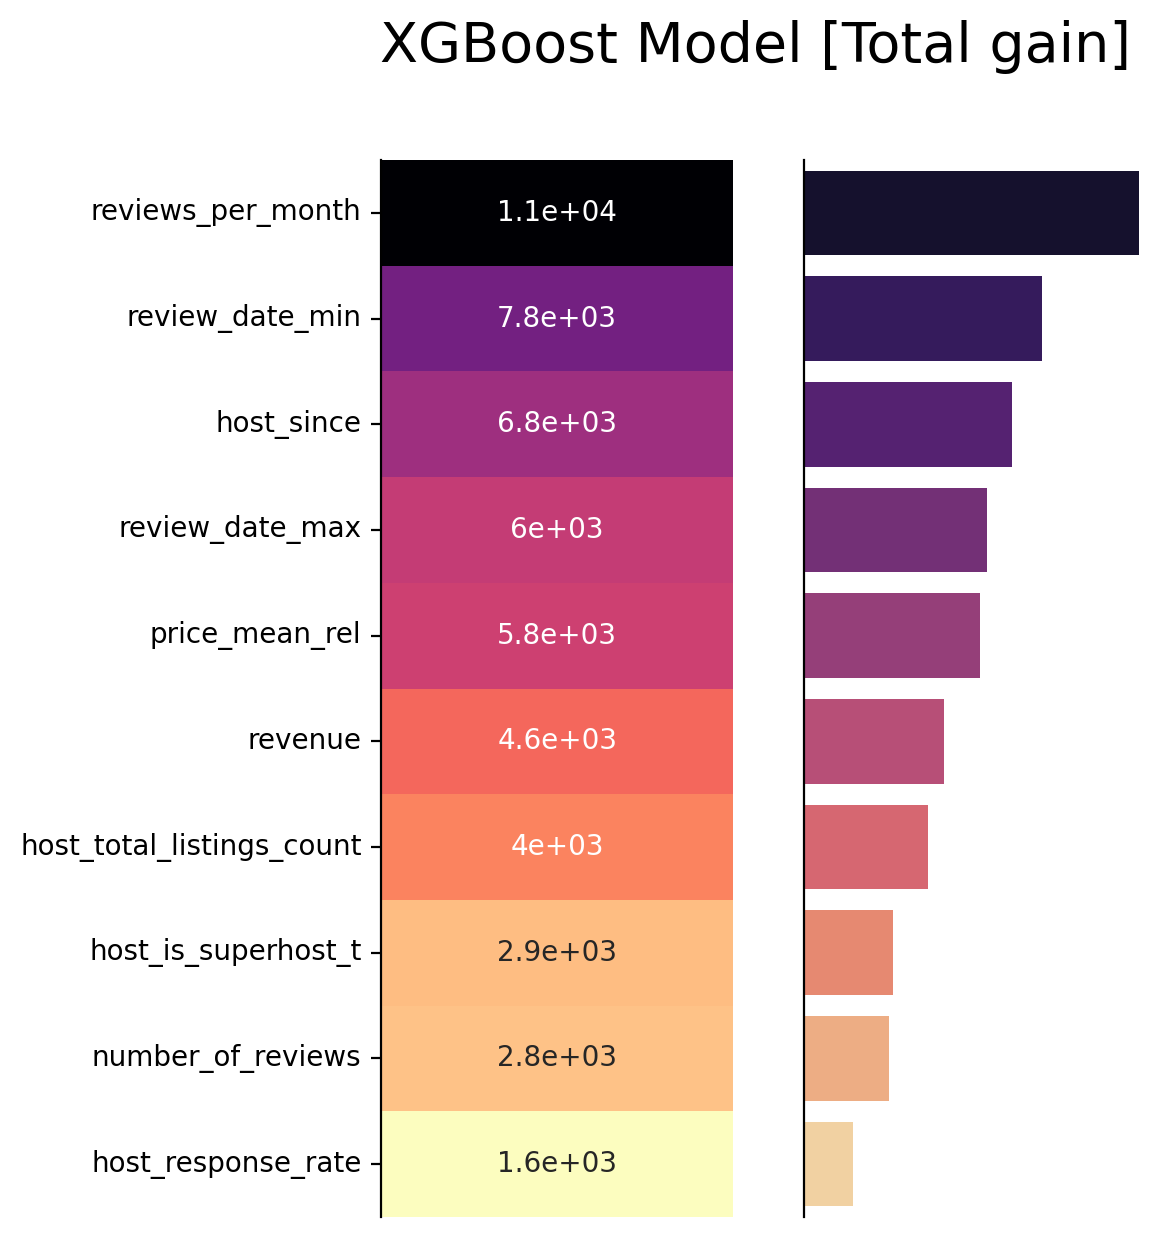

In [15]:
# listing the most important features plus the target feature
most_important_features = list(most_important_XGBoost.iloc[:10].index) + ['review_scores_rating']
# creating a copy of the dataset in memory to be used on the trainig process
df_refined_feed_model = df_refined[most_important_features].copy()

# using the standard scaler to standardize the data
scaler = StandardScaler()

# separating the train and target features
X = df_refined_feed_model[most_important_features].drop('review_scores_rating', axis=1)
y = df_refined_feed_model['review_scores_rating']

# train and test datasets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# standardization of the dataset
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# check the shape of the train and test datasets
print(f'features X_train: {len(X_train[1])}\nfeatures X_test: {len(X_test[1])}')

# Learning - XGBoost
xgbc = XGBRegressor()
xgbc.fit(X_train, y_train)
xgbc_pred_train=xgbc.predict(X_train)
xgbc_pred_test=xgbc.predict(X_test)

# performing crossvalidation test 
xgscore = np.mean(cross_val_score(estimator=xgbc,
                       X=X_train, y=y_train, cv=5))
# printing cross validation results
print(f'XGBoost cross val score: {xgscore}')

# analysing train and test data results
train_score_xgbc =  r2_score(y_train, xgbc_pred_train)
test_score_xgbc = r2_score(y_test, xgbc_pred_test)
# printing r2 scores of training and test
print(f'test score: {test_score_xgbc} \ntrain score: {train_score_xgbc}')

# getting the most important features
dict_importance = xgbc.get_booster().get_score(importance_type="total_gain")
d={}
# cleanse the data
for index, value in dict_importance.items():
    d[X.columns[int(index[1:])]] = value
# transforming data to a dataframe
most_important_XGBoost = pd.DataFrame(d, index=['Total gain']).T
most_important_XGBoost = most_important_XGBoost[['Total gain']].sort_values(ascending=False, by='Total gain')

# plot most important features
plot_importance(most_important_XGBoost, 'Total gain', 'XGBoost Model [Total gain]')

#### Using the review scores

features X_train: 4
features X_test: 4
XGBoost cross val score: 0.8496045038305494
test score: 0.851460983905282 
train score: 0.8675059009743185


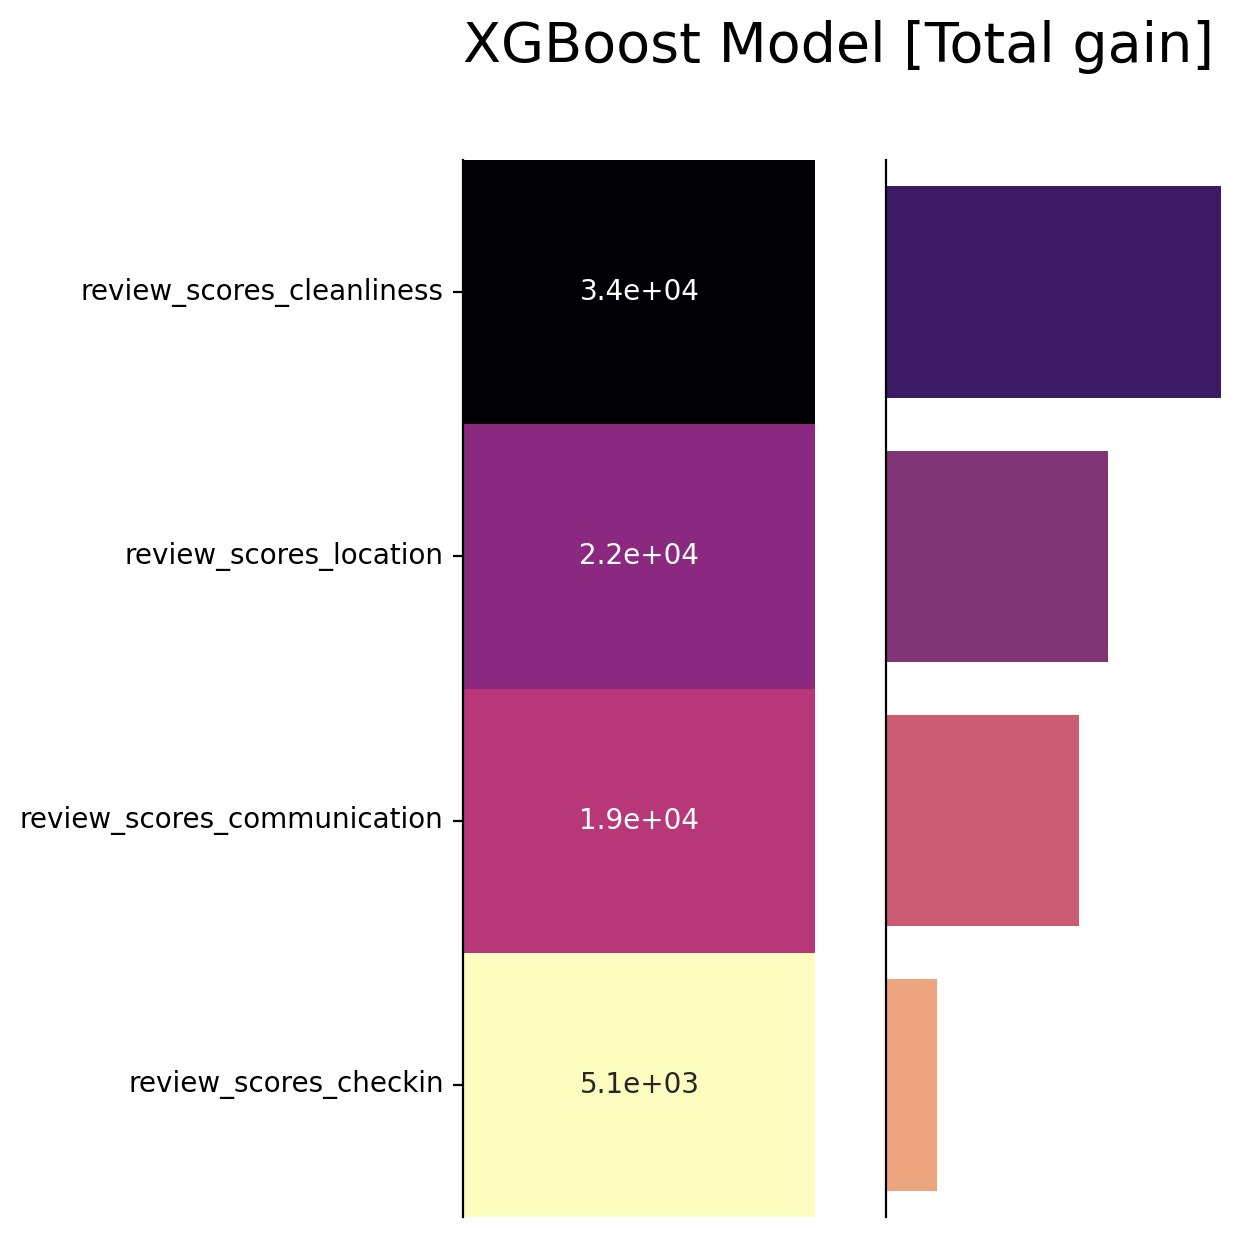

In [16]:
# listing the features to be used on the training model
most_important_features = [col for col in df_refined.columns if ('review_scores' in col)
                            and('accuracy' not in col)
                            and('value' not in col) ]
# creating a copy of the dataset in memory to be used on the trainig process
df_refined_feed_model = df_refined[most_important_features[:10]].copy()

# using the standard scaler to standardize the data
scaler = StandardScaler()

# separating the train and target features
X = df_refined_feed_model[most_important_features].drop('review_scores_rating', axis=1)
y = df_refined_feed_model['review_scores_rating']

# train and test datasets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# standardization of the dataset
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# check the shape of the train and test datasets
print(f'features X_train: {len(X_train[1])}\nfeatures X_test: {len(X_test[1])}')

# Learning - XGBoost
xgbc = XGBRegressor()
xgbc.fit(X_train, y_train)
xgbc_pred_train=xgbc.predict(X_train)
xgbc_pred_test=xgbc.predict(X_test)

# performing crossvalidation test 
xgscore = np.mean(cross_val_score(estimator=xgbc,
                       X=X_train, y=y_train, cv=5))
# printing cross validation results
print(f'XGBoost cross val score: {xgscore}')

# analysing train and test data results
train_score_xgbc =  r2_score(y_train, xgbc_pred_train)
test_score_xgbc = r2_score(y_test, xgbc_pred_test)
# printing r2 scores of training and test
print(f'test score: {test_score_xgbc} \ntrain score: {train_score_xgbc}')

# getting the most important features
dict_importance = xgbc.get_booster().get_score(importance_type="total_gain")
d={}
# cleanse the data
for index, value in dict_importance.items():
    d[X.columns[int(index[1:])]] = value
# transforming data to a dataframe
most_important_XGBoost_review = pd.DataFrame(d, index=['Total gain']).T
most_important_XGBoost_review = most_important_XGBoost_review[['Total gain']].sort_values(ascending=False, by='Total gain')

# plot most important features
plot_importance(most_important_XGBoost_review, 'Total gain', 'XGBoost Model [Total gain]')

## Results

### Question 1
Which are the 10 most important characteristics to influence the overall review of an acomodation?

In [17]:
most_important_XGBoost = pd.read_csv('datasets/refined/most_important_XGBoost.csv', index_col=0)
most_important_XGBoost.iloc[:10]

,Total gain
reviews_per_month,10454.020508
review_date_min,5663.754883
host_since,4235.670410
review_date_max,4164.976074
number_of_reviews,3999.412354
host_total_listings_count,3146.814697
host_is_superhost_t,2892.630859
revenue,2478.561523
host_response_rate,1391.402710
price_mean_rel,1348.076050


### Question 2
What are the general differences between a top rated acomodation and a almost top one?

In [18]:
# Creating the feature score_group to further answer the questions
df_refined['score_group'] = pd.qcut(df_refined['review_scores_rating'], q=2, labels=['low', 'high'])

In [19]:
df_refined.groupby('score_group')[list(most_important_XGBoost.iloc[:15].index)+['review_scores_rating']].median()

,reviews_per_month,review_date_min,host_since,review_date_max,number_of_reviews,host_total_listings_count,host_is_superhost_t,revenue,host_response_rate,price_mean_rel,price_min,review_date_mean,price_min_rel,price_max_rel,host_acceptance_rate,review_scores_rating
score_group,,,,,,,,,,,,,,,,
low,1.04,59.0,2202.0,1150.0,22.0,2.0,0.0,22066.0,100.0,0.565253,105.0,761.942857,0.569389,0.494911,95.0,4.68
high,0.84,60.0,2261.0,933.0,12.0,1.0,1.0,29837.8,100.0,0.639502,130.0,638.000000,0.683267,0.544562,95.0,5.00


The analysis is made based on the median values of each one, so that the outliars do not influence the observations so much.
1. **reviews_per_month** - the top acomodatios receives generally less reviews per month than the not so top ones.
2. **review_date_min** - there are no huge difference betwwen them.
3. **host_since** - the hosts of the top acomodations are in generall hosts for a longer period in AirBnb.	
4. **review_date_max** - the higher ranked acomodations are generally newer than their counterparts.
5. **number_of_reviews** - the higher ranked acomodations have less reviews.
6. **host_total_listings_count** - the hosts owns less acomodations for the higher ranked listings.
7. **revenue** - The revenue related to the top acomodations is higher than the others.	
8. **price_min** - The acomodation price of the top ranked acomodations is higher than the others. 
9. **host_acceptance_rate**	- no difference observed
10. **host_response_rate** - no difference obeserved
11. **price_max_rel** - The acomodation price of the top ranked acomodations is higher than the others. 
12. **host_is_superhost_t** - Being a superhost is a sign of the most well ranked acomodations.


### Question 3
Which are the main review aspects that influences the overall review score?

In [22]:
most_important_XGBoost_review

,Total gain
review_scores_cleanliness,33697.066406
review_scores_location,22334.484375
review_scores_communication,19342.439453
review_scores_checkin,5142.828613
